### Nombre: Jorge Arévalo
### Docente: Ing. Diego Quisi
### Materia: Simulación

# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [37]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2020-11-14,634423,66.0,490.0,867.0,109.0,104.0,0.0,2.0,11859.0,...,63.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,57.0,69.0
320,2020-11-15,597736,205.0,532.0,844.0,0.0,171.0,0.0,1.0,8468.0,...,0.0,0.0,0.0,301.0,9.0,0.0,0.0,0.0,4.0,21.0
321,2020-11-16,504453,163.0,597.0,860.0,147.0,146.0,0.0,0.0,5645.0,...,563.0,0.0,0.0,911.0,16.0,0.0,0.0,0.0,26.0,0.0
322,2020-11-17,554913,65.0,602.0,910.0,42.0,77.0,0.0,0.0,7895.0,...,201.0,0.0,0.0,387.0,2.0,0.0,0.0,0.0,64.0,111.0


Imprimos los resultados y agregamos el numero del dia


In [39]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
319,318,1161.0
320,319,953.0
321,320,668.0
322,321,381.0


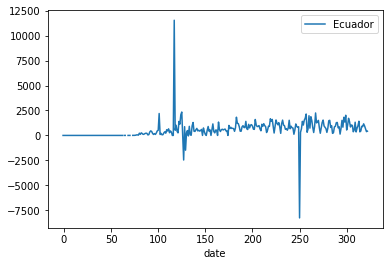

In [40]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [41]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)


663.0
701.953488372093


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [42]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

181767


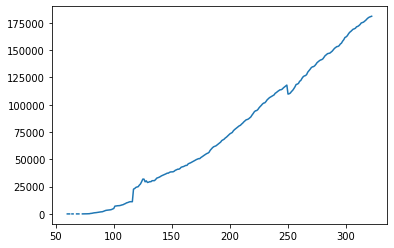

In [43]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]-7):
    x.append(i)
    y.append(int(y[-1] + mediana))
probabilistico=y[319]
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

# Implementar
#### 1. Comparar el modelo de predicion matematico vs probabilidad.

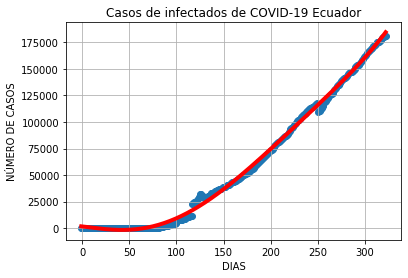

In [44]:
from sklearn.preprocessing import PolynomialFeatures

x = list(df_t.iloc[:, 0]) 
y = list(df_t.iloc [:, 1]) 

y= np.nan_to_num(y)
x=np.array(x).reshape(-1,1)
y=np.array(y).reshape(-1,1)
poly = PolynomialFeatures(degree=5, include_bias=False)
x_poly = poly.fit_transform(x)

model = linear_model.LinearRegression()

model.fit(x_poly, y)
y_pred = model.predict(x_poly)
y_pred = y_pred-7
plt.title('Casos de infectados de COVID-19 Ecuador')
plt.scatter(x, y)
plt.plot(x, y_pred, color='r',lw=4)
plt.grid(True)
plt.xlabel('DIAS')
plt.ylabel('NÚMERO DE CASOS')
plt.show()

Al comparar el modelo matemático con el probabilístico, el modelo que mejor se ajusta es el Polinomial ya que es muy similar a la Regresión lineal pero con una ligera desviación en la forma en que tratamos nuestro espacio.

#### 2. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

In [45]:
#Implementar
#--- El modelo basado en probabilidad ---
probabilistico=probabilistico-7
print('Casos hace 7 días: ',np.round(valorProbabilistico,1))

Número de casos hace 7 días:  178667.0


In [46]:
# Modelo Logistico
logistico=y_pred[319-7]
print('Casos hace 7 días:',np.round(logistico,0))

Casos hace 7 días: [172142.]


####  > Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

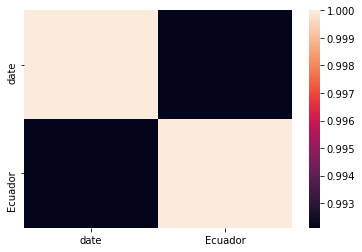

In [52]:
import seaborn as sns
corr = df_t.corr()
sns.heatmap(corr, 
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)

## Analisis
La regresión polinomial es una forma de regresión lineal en la que la relación entre la variable independiente x y la variable dependiente y es modelada como un polinomio de grado n en x.

## Conclusiones
Se realizo la comparación en donde se puede ver que la regresión polinomial es la mejor opción para demostrar los casos del COVID – 19 

## Criterio personal (politico, economico y  social de la situacion)

Se debe tener presente las medidas de prevención contra el virus ya que así podremos evitar que se aumente los contagios en el país.  

Este virus ha afectado a varias empresas ya que por evitar el contagio deben cerrarse la cual, tambien en algunas empresas despedían a empleados por lo que estaba en stop el negocio y no generaban ingresos. El país presente grandes desequilibrios en dinero ya que por las restricciones se tiene una diferente manera de trabajar

Mediante este análisis podemos ver en qué estado se encuentra el país por lo que debemos seguir con las medidas de prevención contra el COVID-19 para así evitar contagios ya que en las gráficas se puede observar altos índices de casos nuevos y de numerosas muertes en el Ecuador.


# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/